C:\Users\Koustav\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



Month: 2023-05 (Investment: ₹78.06)
TV:                  Allocation: ₹      8.70, Percentage:  11.15%, Raw Weight: 0.279827, Norm Weight: 0.111451
Digital:             Allocation: ₹      0.26, Percentage:   0.33%, Raw Weight: 0.036236, Norm Weight: 0.014432
Sponsorship:         Allocation: ₹      3.46, Percentage:   4.43%, Raw Weight: 0.128615, Norm Weight: 0.051225
Content Marketing:   Allocation: ₹      7.05, Percentage:   9.04%, Raw Weight: 0.232355, Norm Weight: 0.092543
Online marketing:    Allocation: ₹     16.67, Percentage:  21.36%, Raw Weight: 0.509787, Norm Weight: 0.203041
Affiliates:          Allocation: ₹     16.30, Percentage:  20.88%, Raw Weight: 0.498767, Norm Weight: 0.198652
SEM:                 Allocation: ₹      4.79, Percentage:   6.13%, Raw Weight: 0.166967, Norm Weight: 0.066501
Radio:               Allocation: ₹     11.66, Percentage:  14.94%, Raw Weight: 0.365200, Norm Weight: 0.145454
Other:               Allocation: ₹      9.16, Percentage:  11.74%, Raw Weig

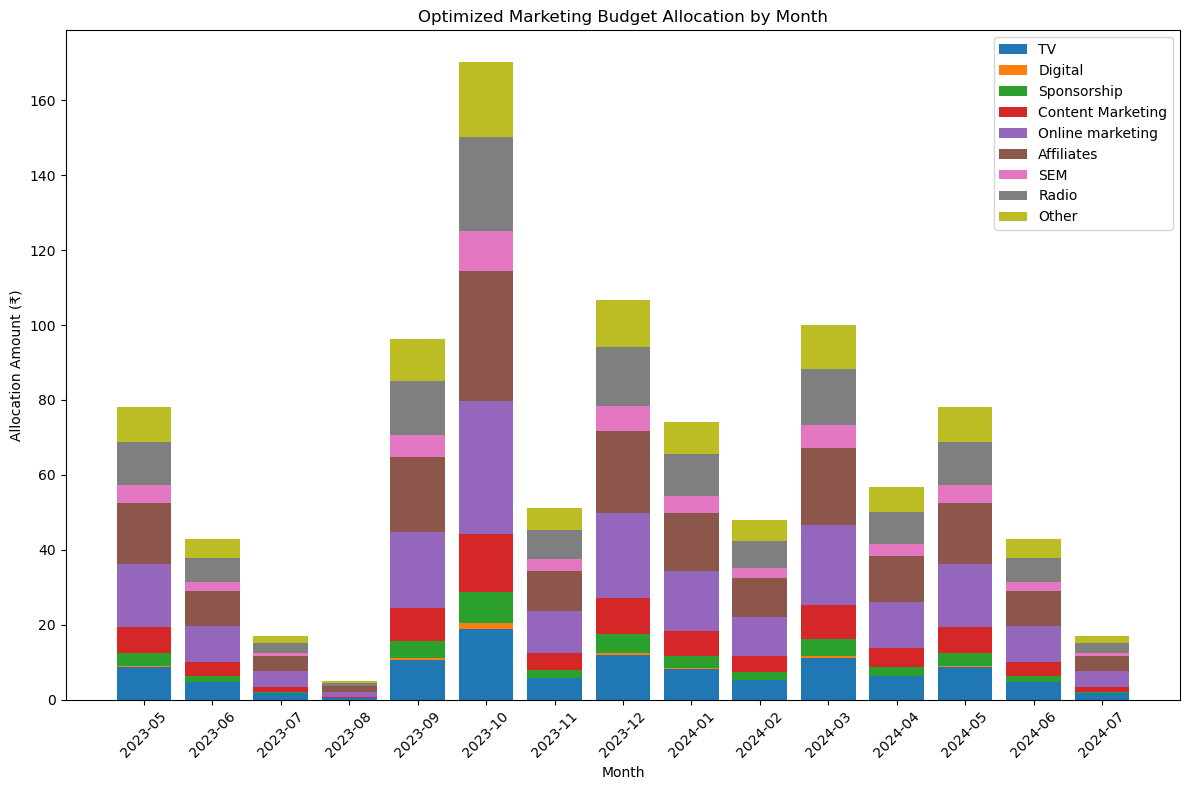

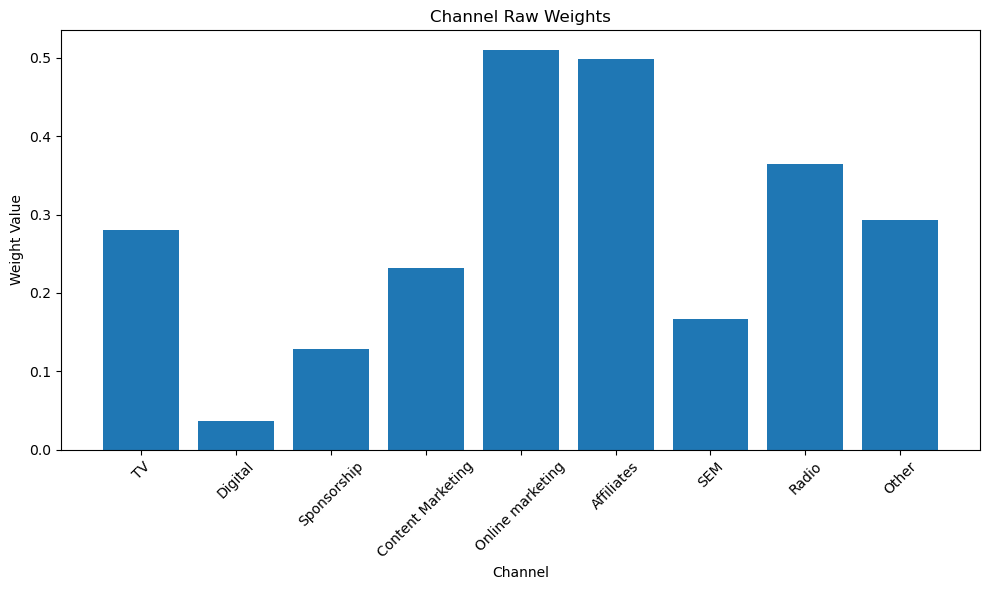

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

# Configuration
CHANNELS = ["TV", "Digital", "Sponsorship", "Content Marketing", 
            "Online marketing", "Affiliates", "SEM", "Radio", "Other"]
RANDOM_SEED = 42

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def main():
    # Load and prepare data
    df = pd.read_csv("Monthly_updated_2.csv")
    df.columns = df.columns.str.strip()
    
    # Filter existing channels
    existing_channels = [col for col in CHANNELS if col in df.columns]
    num_channels = len(existing_channels)
    
    # Get total investments and GMV
    total_investments = df["Total Investment"].values
    gmv_values = df["gmv"].values if "gmv" in df.columns else None
    num_months = len(total_investments)
    
    # Extract month/year information for better reporting
    month_years = df["Month_Year"].values if "Month_Year" in df.columns else [f"Month {i+1}" for i in range(num_months)]
    
    # Analyze historical data to understand channel effectiveness
    channel_data = df[existing_channels].values
    channel_percentages = channel_data / np.sum(channel_data, axis=1)[:, np.newaxis]
    
    # Calculate historical average allocation percentages
    avg_percentages = np.mean(channel_percentages, axis=0)
    
    # Calculate correlation between channel investment and GMV if available
    channel_effectiveness = {}
    if gmv_values is not None:
        for i, channel in enumerate(existing_channels):
            correlation = np.corrcoef(channel_data[:, i], gmv_values)[0, 1]
            channel_effectiveness[channel] = max(0.001, correlation)  # Ensure positive values
    else:
        # If GMV not available, use equal effectiveness
        for channel in existing_channels:
            channel_effectiveness[channel] = 1.0
    
    # Extract weights but keep them unnormalized for revenue calculation
    weights_values = np.array([channel_effectiveness[ch] for ch in existing_channels])
    
    # Create normalized weights for reporting
    normalized_weights = weights_values / np.sum(weights_values)
    
    def objective_function(allocations, total_investment, weights):
        """
        Maximize revenue based on allocations and effectiveness
        Revenue model: sum(w_i * log(x_i + 1)) where:
        - x_i is the allocation amount for channel i
        - w_i is the effectiveness weight for channel i
        """
        # Ensure allocations are positive and sum to total investment
        allocations = np.abs(allocations)
        allocations = allocations / np.sum(allocations) * total_investment
        
        # Calculate revenue using log-based diminishing returns model with unnormalized weights
        revenue = np.sum(weights * np.log(allocations + 1))
        
        # We minimize the negative revenue
        return -revenue
    
    def constraint_sum(allocations):
        """Constraint: Sum of allocations should equal 1 (will be scaled later)"""
        return np.sum(allocations) - 1.0
    
    def optimize_monthly_allocation(month_idx, total_inv):
        """Optimize allocations for a single month"""
        # Initial guess: use historical averages or equal allocation
        initial_guess = avg_percentages if len(avg_percentages) > 0 else np.ones(num_channels) / num_channels
        
        # Bounds: ensure all allocations are positive (0 to 100%)
        bounds = [(0.001, 1.0) for _ in range(num_channels)]
        
        # Constraints: sum of allocation percentages = 1
        constraints = [{'type': 'eq', 'fun': constraint_sum}]
        
        # Optimize
        result = minimize(
            lambda x: objective_function(x, total_inv, weights_values),  # Using unnormalized weights
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        # Scale optimized percentages to total investment
        opt_percentages = result.x / np.sum(result.x)
        opt_allocations = opt_percentages * total_inv
        revenue = -result.fun  # This is now unnormalized
        
        return opt_percentages, opt_allocations, revenue
    
    # Process each month and generate results
    all_results = []
    for month_idx in range(num_months):
        total_inv = total_investments[month_idx]
        month_year = month_years[month_idx]
        
        # Optimize allocations
        percentages, allocations, revenue = optimize_monthly_allocation(month_idx, total_inv)
        
        # Store results
        month_result = {
            'Month': month_year,
            'Total_Investment': total_inv,
            'Projected_Revenue': revenue
        }
        
        # Add channel allocations
        for i, channel in enumerate(existing_channels):
            month_result[f'{channel}_Allocation'] = allocations[i]
            month_result[f'{channel}_Percentage'] = percentages[i] * 100
            month_result[f'{channel}_Raw_Weight'] = weights_values[i]
            month_result[f'{channel}_Normalized_Weight'] = normalized_weights[i]
        
        all_results.append(month_result)
        
        # Print formatted results
        print(f"\nMonth: {month_year} (Investment: ₹{total_inv:,.2f})")
        for i, channel in enumerate(existing_channels):
            print(f"{channel+':':<20} Allocation: ₹{allocations[i]:>10,.2f}, "
                  f"Percentage: {percentages[i]*100:>6.2f}%, "
                  f"Raw Weight: {weights_values[i]:>8.6f}, "
                  f"Norm Weight: {normalized_weights[i]:>8.6f}")
        print(f"Projected Revenue Value (Unnormalized): {revenue:,.2f}")
    
    # Create a DataFrame with all results
    results_df = pd.DataFrame(all_results)
    
    # Save results to CSV
    results_df.to_csv("marketing_optimization_results.csv", index=False)
    print("\nResults saved to marketing_optimization_results.csv")
    
    # Generate visualization of the allocation
    plt.figure(figsize=(12, 8))
    
    # Prepare data for stacked bar chart
    month_labels = results_df['Month'].values
    allocation_data = {channel: results_df[f'{channel}_Allocation'].values for channel in existing_channels}
    
    # Create stacked bar chart
    bottom = np.zeros(num_months)
    for channel in existing_channels:
        plt.bar(month_labels, allocation_data[channel], bottom=bottom, label=channel)
        bottom += allocation_data[channel]
    
    plt.title('Optimized Marketing Budget Allocation by Month')
    plt.xlabel('Month')
    plt.ylabel('Allocation Amount (₹)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig('budget_allocation.png')
    print("Visualization saved as budget_allocation.png")
    
    # Create a second visualization for weights
    plt.figure(figsize=(10, 6))
    
    # Plot bar chart of channel weights
    plt.bar(existing_channels, weights_values)
    plt.title('Channel Raw Weights')
    plt.xlabel('Channel')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save weight plot
    plt.savefig('channel_weights.png')
    print("Channel weights visualization saved as channel_weights.png")

if __name__ == "__main__":
    main()

Starting bilevel optimization to find optimal weights...


C:\Users\Koustav\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\Koustav\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\Koustav\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])



Optimal weights found:
TV: Raw Weight = 0.139913, Normalized = 0.053217
Digital: Raw Weight = 0.018118, Normalized = 0.006891
Sponsorship: Raw Weight = 0.064307, Normalized = 0.024460
Content Marketing: Raw Weight = 0.116177, Normalized = 0.044188
Online marketing: Raw Weight = 0.764680, Normalized = 0.290849
Affiliates: Raw Weight = 0.748151, Normalized = 0.284562
SEM: Raw Weight = 0.083484, Normalized = 0.031753
Radio: Raw Weight = 0.547800, Normalized = 0.208357
Other: Raw Weight = 0.146504, Normalized = 0.055723

Month: 2023-05 (Investment: ₹78.06)
TV:                  Allocation: ₹      3.61, Percentage:   4.62%, Raw Weight: 0.139913, Norm Weight: 0.053217
Digital:             Allocation: ₹      0.08, Percentage:   0.10%, Raw Weight: 0.018118, Norm Weight: 0.006891
Sponsorship:         Allocation: ₹      1.12, Percentage:   1.43%, Raw Weight: 0.064307, Norm Weight: 0.024460
Content Marketing:   Allocation: ₹      2.82, Percentage:   3.62%, Raw Weight: 0.116177, Norm Weight: 0.044

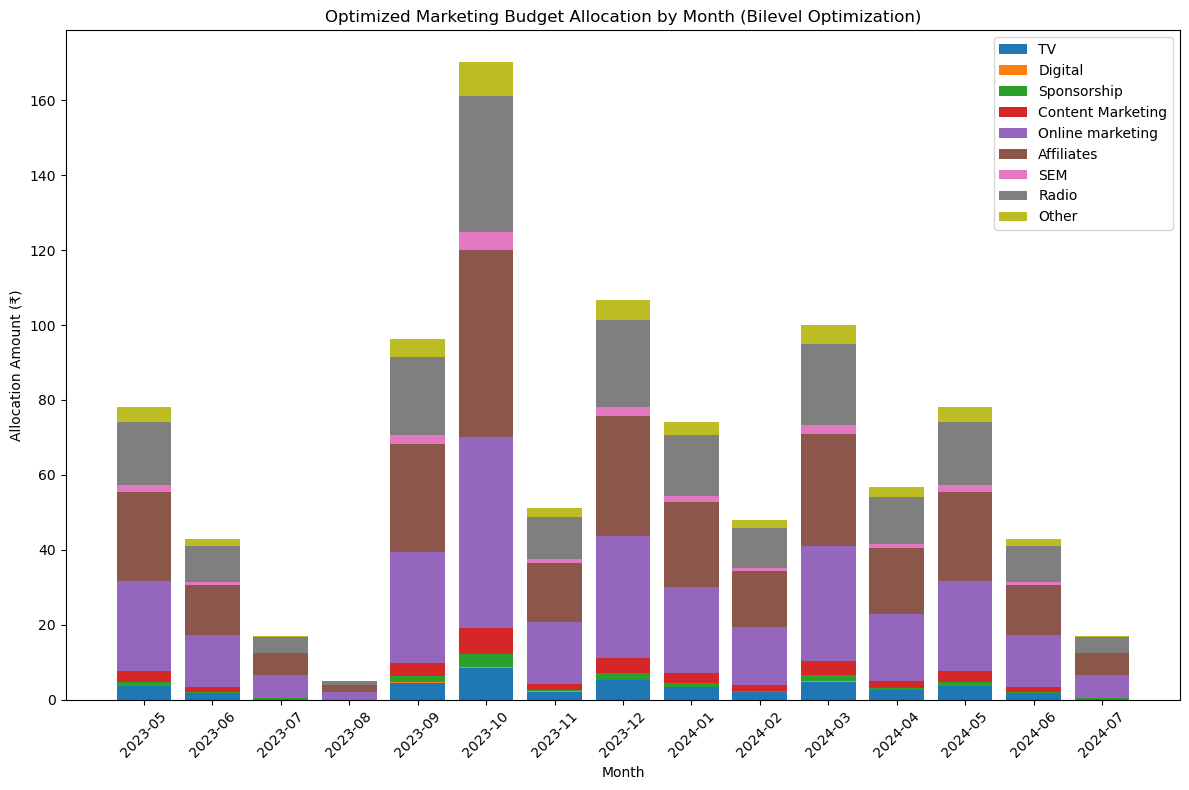

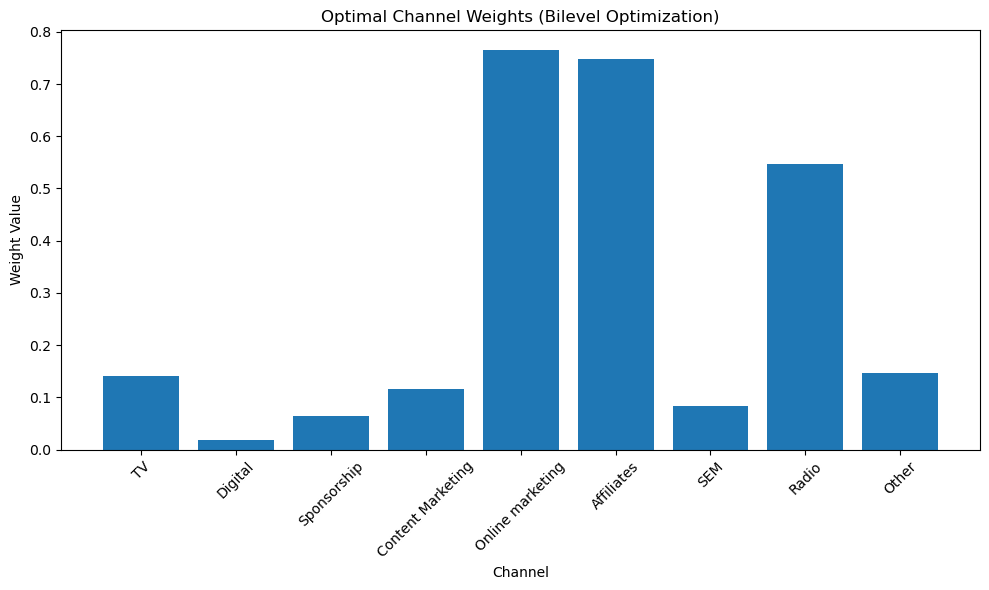

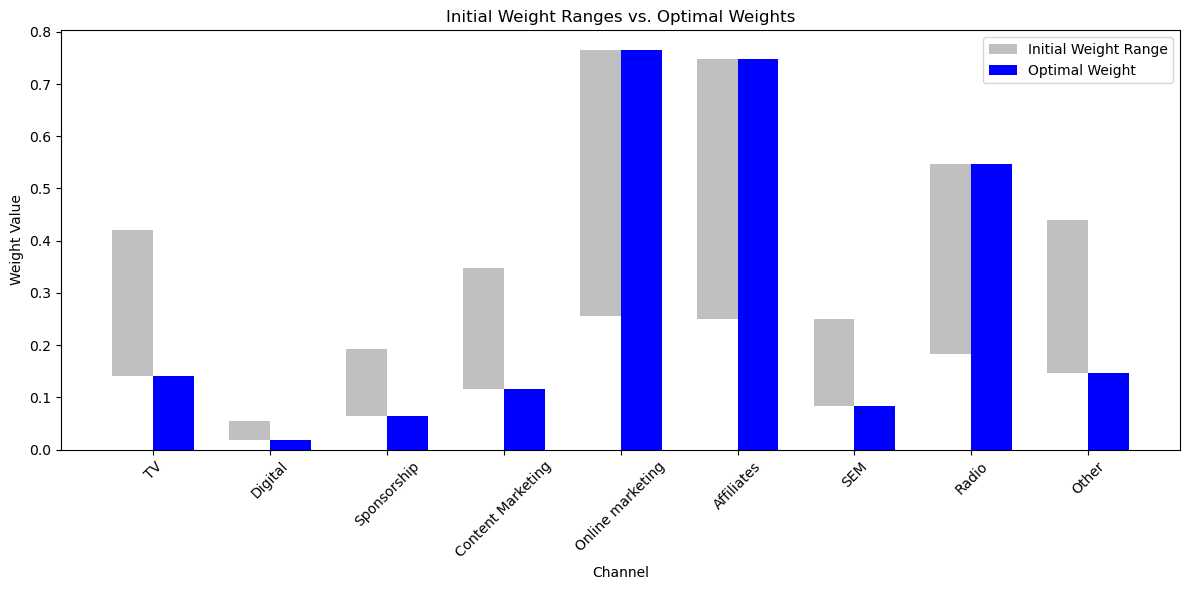

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

# Configuration
CHANNELS = ["TV", "Digital", "Sponsorship", "Content Marketing", 
            "Online marketing", "Affiliates", "SEM", "Radio", "Other"]
RANDOM_SEED = 42

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def main():
    # Load and prepare data
    df = pd.read_csv("Monthly_updated_2.csv")
    df.columns = df.columns.str.strip()
    
    # Filter existing channels
    existing_channels = [col for col in CHANNELS if col in df.columns]
    num_channels = len(existing_channels)
    
    # Get total investments and GMV
    total_investments = df["Total Investment"].values
    gmv_values = df["gmv"].values if "gmv" in df.columns else None
    num_months = len(total_investments)
    
    # Extract month/year information for better reporting
    month_years = df["Month_Year"].values if "Month_Year" in df.columns else [f"Month {i+1}" for i in range(num_months)]
    
    # Analyze historical data to understand channel effectiveness
    channel_data = df[existing_channels].values
    channel_percentages = channel_data / np.sum(channel_data, axis=1)[:, np.newaxis]
    
    # Calculate historical average allocation percentages
    avg_percentages = np.mean(channel_percentages, axis=0)
    
    # Calculate correlation between channel investment and GMV to establish weight ranges
    weight_ranges = {}
    if gmv_values is not None:
        for i, channel in enumerate(existing_channels):
            correlation = np.corrcoef(channel_data[:, i], gmv_values)[0, 1]
            base_weight = max(0.001, correlation)
            
            # Define a reasonable range around the correlation coefficient
            # Lower bound: 50% of base weight, Upper bound: 150% of base weight
            weight_ranges[channel] = (max(0.001, base_weight * 0.5), base_weight * 1.5)
    else:
        # If GMV not available, use equal effectiveness with wide ranges
        for channel in existing_channels:
            weight_ranges[channel] = (0.001, 2.0)
    
    # Function to convert weight parameters to a proper weight vector
    def get_weights_from_params(weight_params):
        """Convert optimization parameters to channel weights"""
        weights = np.zeros(num_channels)
        for i, channel in enumerate(existing_channels):
            min_w, max_w = weight_ranges[channel]
            # Scale the parameter (0-1) to the weight range
            weights[i] = min_w + weight_params[i] * (max_w - min_w)
        return weights
    
    # Lower-level optimization: Optimal allocation given weights
    def lower_level_optimization(weights, month_idx, total_inv):
        """
        Find optimal allocations given a set of weights and total investment
        """
        def objective_function(allocations):
            """
            Maximize revenue based on allocations and effectiveness
            Revenue model: sum(w_i * log(x_i + 1))
            """
            # Ensure allocations are positive and sum to total investment
            allocations = np.abs(allocations)
            allocations = allocations / np.sum(allocations) * total_inv
            
            # Calculate revenue using log-based diminishing returns model
            revenue = np.sum(weights * np.log(allocations + 1))
            
            # We minimize the negative revenue
            return -revenue
        
        def constraint_sum(allocations):
            """Constraint: Sum of allocations should equal 1 (will be scaled later)"""
            return np.sum(allocations) - 1.0
        
        # Initial guess: use historical averages or equal allocation
        initial_guess = avg_percentages if len(avg_percentages) > 0 else np.ones(num_channels) / num_channels
        
        # Bounds: ensure all allocations are positive (0 to 100%)
        bounds = [(0.001, 1.0) for _ in range(num_channels)]
        
        # Constraints: sum of allocation percentages = 1
        constraints = [{'type': 'eq', 'fun': constraint_sum}]
        
        # Optimize
        result = minimize(
            objective_function,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        # Scale optimized percentages to total investment
        opt_percentages = result.x / np.sum(result.x)
        opt_allocations = opt_percentages * total_inv
        revenue = -result.fun
        
        return opt_percentages, opt_allocations, revenue
    
    # Upper-level optimization: Find optimal weights
    def upper_level_objective(weight_params):
        """
        Objective function for the upper-level optimization.
        Find weights that maximize predictive performance across all months.
        """
        # Convert parameters to weights
        weights = get_weights_from_params(weight_params)
        
        # Variable to store performance metric
        total_prediction_error = 0
        predicted_gmvs = []
        
        # Calculate allocations and predicted GMV for each month
        for month_idx in range(num_months - 1):  # Use all but last month for training
            total_inv = total_investments[month_idx]
            
            # Get optimal allocations for these weights
            _, allocations, predicted_revenue = lower_level_optimization(weights, month_idx, total_inv)
            
            # Store predicted revenue as proxy for GMV
            predicted_gmvs.append(predicted_revenue)
        
        # Calculate error between predicted and actual GMV trend
        if gmv_values is not None:
            # Scale predicted revenues to match the scale of GMV
            scaling_factor = np.mean(gmv_values[:-1]) / np.mean(predicted_gmvs) if np.mean(predicted_gmvs) > 0 else 1
            scaled_predictions = np.array(predicted_gmvs) * scaling_factor
            
            # Calculate error between scaled predictions and actual GMV
            errors = scaled_predictions - gmv_values[:-1]
            total_prediction_error = np.sum(errors**2)  # Sum of squared errors
        else:
            # If no GMV data, optimize for maximum predicted revenue
            total_prediction_error = -np.sum(predicted_gmvs)
        
        return total_prediction_error
    
    # Run bilevel optimization
    def run_bilevel_optimization():
        """
        Run the bilevel optimization to find optimal weights and allocations
        """
        print("Starting bilevel optimization to find optimal weights...")
        
        # Initial guess for weight parameters (scaled to 0-1 range)
        initial_weight_params = np.ones(num_channels) * 0.5  # Start in the middle of each range
        
        # Bounds for weight parameters (0-1, will be scaled to actual weight ranges)
        weight_bounds = [(0, 1) for _ in range(num_channels)]
        
        # Optimize weights
        upper_result = minimize(
            upper_level_objective,
            initial_weight_params,
            method='L-BFGS-B',  # Different method more suited for upper level
            bounds=weight_bounds,
            options={'disp': True, 'maxiter': 100}
        )
        
        # Get optimal weights
        optimal_weight_params = upper_result.x
        optimal_weights = get_weights_from_params(optimal_weight_params)
        
        # Normalize weights for reporting
        normalized_weights = optimal_weights / np.sum(optimal_weights)
        
        print("\nOptimal weights found:")
        for i, channel in enumerate(existing_channels):
            print(f"{channel}: Raw Weight = {optimal_weights[i]:.6f}, Normalized = {normalized_weights[i]:.6f}")
        
        return optimal_weights, normalized_weights
    
    # Optimize weights using bilevel approach
    optimal_weights, normalized_weights = run_bilevel_optimization()
    
    # Process each month with optimal weights to generate final allocation recommendations
    all_results = []
    for month_idx in range(num_months):
        total_inv = total_investments[month_idx]
        month_year = month_years[month_idx]
        
        # Optimize allocations using the optimal weights
        percentages, allocations, revenue = lower_level_optimization(optimal_weights, month_idx, total_inv)
        
        # Store results
        month_result = {
            'Month': month_year,
            'Total_Investment': total_inv,
            'Projected_Revenue': revenue
        }
        
        # Add channel allocations
        for i, channel in enumerate(existing_channels):
            month_result[f'{channel}_Allocation'] = allocations[i]
            month_result[f'{channel}_Percentage'] = percentages[i] * 100
            month_result[f'{channel}_Raw_Weight'] = optimal_weights[i]
            month_result[f'{channel}_Normalized_Weight'] = normalized_weights[i]
        
        all_results.append(month_result)
        
        # Print formatted results
        print(f"\nMonth: {month_year} (Investment: ₹{total_inv:,.2f})")
        for i, channel in enumerate(existing_channels):
            print(f"{channel+':':<20} Allocation: ₹{allocations[i]:>10,.2f}, "
                  f"Percentage: {percentages[i]*100:>6.2f}%, "
                  f"Raw Weight: {optimal_weights[i]:>8.6f}, "
                  f"Norm Weight: {normalized_weights[i]:>8.6f}")
        print(f"Projected Revenue Value: {revenue:,.2f}")
    
    # Create a DataFrame with all results
    results_df = pd.DataFrame(all_results)
    
    # Save results to CSV
    results_df.to_csv("bilevel_optimization_results.csv", index=False)
    print("\nResults saved to bilevel_optimization_results.csv")
    
    # Generate visualization of the allocation
    plt.figure(figsize=(12, 8))
    
    # Prepare data for stacked bar chart
    month_labels = results_df['Month'].values
    allocation_data = {channel: results_df[f'{channel}_Allocation'].values for channel in existing_channels}
    
    # Create stacked bar chart
    bottom = np.zeros(num_months)
    for channel in existing_channels:
        plt.bar(month_labels, allocation_data[channel], bottom=bottom, label=channel)
        bottom += allocation_data[channel]
    
    plt.title('Optimized Marketing Budget Allocation by Month (Bilevel Optimization)')
    plt.xlabel('Month')
    plt.ylabel('Allocation Amount (₹)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig('bilevel_budget_allocation.png')
    print("Visualization saved as bilevel_budget_allocation.png")
    
    # Create a second visualization for weights
    plt.figure(figsize=(10, 6))
    
    # Plot bar chart of channel weights
    plt.bar(existing_channels, optimal_weights)
    plt.title('Optimal Channel Weights (Bilevel Optimization)')
    plt.xlabel('Channel')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save weight plot
    plt.savefig('bilevel_channel_weights.png')
    print("Channel weights visualization saved as bilevel_channel_weights.png")
    
    # Create additional visualization comparing initial weight ranges and optimal weights
    plt.figure(figsize=(12, 6))
    
    # Width of the bars
    bar_width = 0.35
    
    # Positions for the bars
    index = np.arange(num_channels)
    
    # Plot initial weight ranges
    lower_bounds = np.array([weight_ranges[ch][0] for ch in existing_channels])
    upper_bounds = np.array([weight_ranges[ch][1] for ch in existing_channels])
    
    # Plot bars for weight ranges
    plt.bar(index, upper_bounds - lower_bounds, bar_width, bottom=lower_bounds, alpha=0.5, color='gray', label='Initial Weight Range')
    
    # Plot markers for optimal weights
    plt.bar(index + bar_width, optimal_weights, bar_width, color='blue', label='Optimal Weight')
    
    plt.xlabel('Channel')
    plt.ylabel('Weight Value')
    plt.title('Initial Weight Ranges vs. Optimal Weights')
    plt.xticks(index + bar_width/2, existing_channels, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Save comparison plot
    plt.savefig('weight_comparison.png')
    print("Weight comparison visualization saved as weight_comparison.png")

if __name__ == "__main__":
    main()

Starting bilevel optimization to find optimal weights...
Note: Upper bounds set for channels: {'TV': 0.5, 'Online marketing': 0.5}
Channels 'Radio' and 'Other' excluded from analysis.


C:\Users\Koustav\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



Optimal weights found:
TV: Raw Weight = 0.139913, Normalized = 0.072313
Digital: Raw Weight = 0.018118, Normalized = 0.009364
Sponsorship: Raw Weight = 0.064307, Normalized = 0.033237
Content Marketing: Raw Weight = 0.116177, Normalized = 0.060045
Online marketing: Raw Weight = 0.764680, Normalized = 0.395218
Affiliates: Raw Weight = 0.748151, Normalized = 0.386675
SEM: Raw Weight = 0.083484, Normalized = 0.043148

Month: 2023-05 (Investment: ₹78.06)
TV:                  Allocation: ₹      5.13, Percentage:   6.58%, Raw Weight: 0.139913, Norm Weight: 0.072313
Digital:             Allocation: ₹      0.08, Percentage:   0.10%, Raw Weight: 0.018118, Norm Weight: 0.009364
Sponsorship:         Allocation: ₹      1.82, Percentage:   2.33%, Raw Weight: 0.064307, Norm Weight: 0.033237
Content Marketing:   Allocation: ₹      4.10, Percentage:   5.25%, Raw Weight: 0.116177, Norm Weight: 0.060045
Online marketing:    Allocation: ₹     32.51, Percentage:  41.65%, Raw Weight: 0.764680, Norm Weight

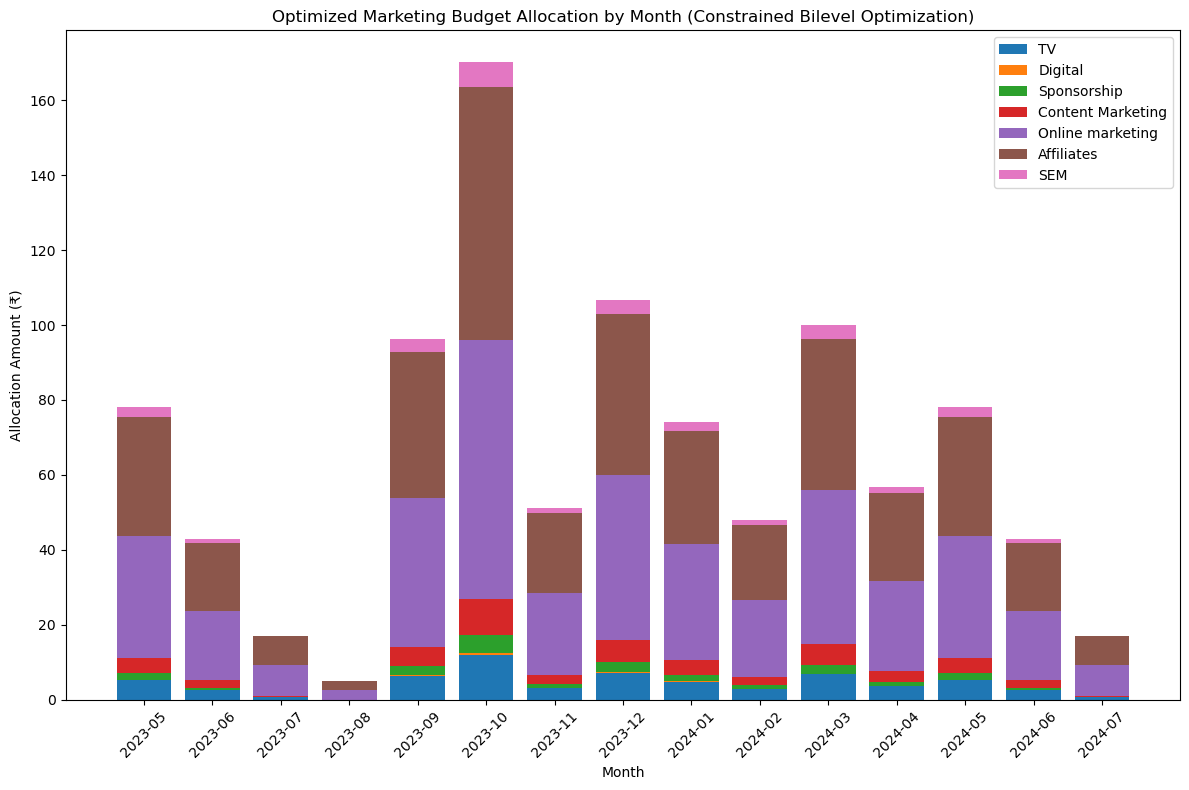

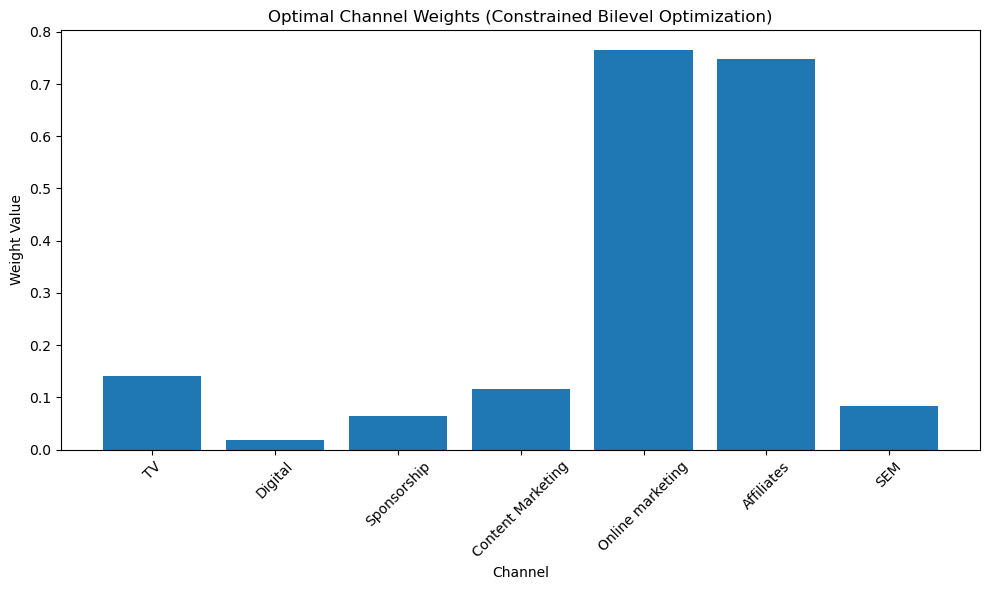

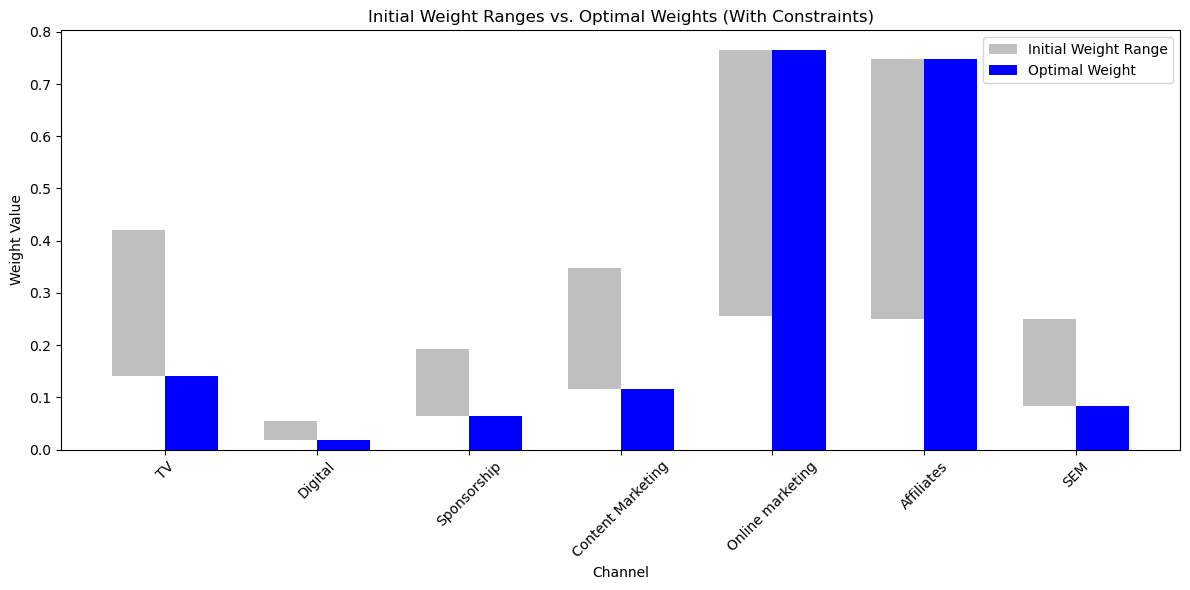

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

# Configuration
CHANNELS = ["TV", "Digital", "Sponsorship", "Content Marketing", 
            "Online marketing", "Affiliates", "SEM"]  # Removed "Radio" and "Other"
RANDOM_SEED = 42

# Channels with upper bound constraints
UPPER_BOUND_CHANNELS = {
    "TV": 0.5,  # 50% max allocation
    "Online marketing": 0.5  # 50% max allocation
}

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def main():
    # Load and prepare data
    df = pd.read_csv("Monthly_updated_2.csv")
    df.columns = df.columns.str.strip()
    
    # Filter existing channels, excluding "Radio" and "Other"
    existing_channels = [col for col in CHANNELS if col in df.columns]
    num_channels = len(existing_channels)
    
    # Get total investments and GMV
    total_investments = df["Total Investment"].values
    gmv_values = df["gmv"].values if "gmv" in df.columns else None
    num_months = len(total_investments)
    
    # Extract month/year information for better reporting
    month_years = df["Month_Year"].values if "Month_Year" in df.columns else [f"Month {i+1}" for i in range(num_months)]
    
    # Analyze historical data to understand channel effectiveness
    channel_data = df[existing_channels].values
    channel_percentages = channel_data / np.sum(channel_data, axis=1)[:, np.newaxis]
    
    # Calculate historical average allocation percentages
    avg_percentages = np.mean(channel_percentages, axis=0)
    
    # Calculate correlation between channel investment and GMV to establish weight ranges
    weight_ranges = {}
    if gmv_values is not None:
        for i, channel in enumerate(existing_channels):
            correlation = np.corrcoef(channel_data[:, i], gmv_values)[0, 1]
            base_weight = max(0.001, correlation)
            
            # Define a reasonable range around the correlation coefficient
            # Lower bound: 50% of base weight, Upper bound: 150% of base weight
            weight_ranges[channel] = (max(0.001, base_weight * 0.5), base_weight * 1.5)
    else:
        # If GMV not available, use equal effectiveness with wide ranges
        for channel in existing_channels:
            weight_ranges[channel] = (0.001, 2.0)
    
    # Function to convert weight parameters to a proper weight vector
    def get_weights_from_params(weight_params):
        """Convert optimization parameters to channel weights"""
        weights = np.zeros(num_channels)
        for i, channel in enumerate(existing_channels):
            min_w, max_w = weight_ranges[channel]
            # Scale the parameter (0-1) to the weight range
            weights[i] = min_w + weight_params[i] * (max_w - min_w)
        return weights
    
    # Lower-level optimization: Optimal allocation given weights
    def lower_level_optimization(weights, month_idx, total_inv):
        """
        Find optimal allocations given a set of weights and total investment
        """
        def objective_function(allocations):
            """
            Maximize revenue based on allocations and effectiveness
            Revenue model: sum(w_i * log(x_i + 1))
            """
            # Ensure allocations are positive and sum to total investment
            allocations = np.abs(allocations)
            allocations = allocations / np.sum(allocations) * total_inv
            
            # Calculate revenue using log-based diminishing returns model
            revenue = np.sum(weights * np.log(allocations + 1))
            
            # We minimize the negative revenue
            return -revenue
        
        def constraint_sum(allocations):
            """Constraint: Sum of allocations should equal 1 (will be scaled later)"""
            return np.sum(allocations) - 1.0
        
        # Create constraints for TV and Online marketing upper bounds
        constraints = [{'type': 'eq', 'fun': constraint_sum}]
        
        # Add upper bound constraints for specific channels
        for channel_name, upper_bound in UPPER_BOUND_CHANNELS.items():
            if channel_name in existing_channels:
                channel_idx = existing_channels.index(channel_name)
                
                # Create a constraint function for this channel's upper bound
                def channel_upper_bound(allocations, idx=channel_idx, bound=upper_bound):
                    """Constraint: Channel allocation should not exceed the upper bound"""
                    return bound - allocations[idx]
                
                constraints.append({
                    'type': 'ineq',
                    'fun': channel_upper_bound
                })
        
        # Initial guess: use historical averages or equal allocation
        initial_guess = avg_percentages if len(avg_percentages) > 0 else np.ones(num_channels) / num_channels
        
        # Bounds: ensure all allocations are positive (0 to 100%)
        bounds = [(0.001, 1.0) for _ in range(num_channels)]
        
        # Optimize
        result = minimize(
            objective_function,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        # Scale optimized percentages to total investment
        opt_percentages = result.x / np.sum(result.x)
        opt_allocations = opt_percentages * total_inv
        revenue = -result.fun
        
        return opt_percentages, opt_allocations, revenue
    
    # Upper-level optimization: Find optimal weights
    def upper_level_objective(weight_params):
        """
        Objective function for the upper-level optimization.
        Find weights that maximize predictive performance across all months.
        """
        # Convert parameters to weights
        weights = get_weights_from_params(weight_params)
        
        # Variable to store performance metric
        total_prediction_error = 0
        predicted_gmvs = []
        
        # Calculate allocations and predicted GMV for each month
        for month_idx in range(num_months - 1):  # Use all but last month for training
            total_inv = total_investments[month_idx]
            
            # Get optimal allocations for these weights
            _, allocations, predicted_revenue = lower_level_optimization(weights, month_idx, total_inv)
            
            # Store predicted revenue as proxy for GMV
            predicted_gmvs.append(predicted_revenue)
        
        # Calculate error between predicted and actual GMV trend
        if gmv_values is not None:
            # Scale predicted revenues to match the scale of GMV
            scaling_factor = np.mean(gmv_values[:-1]) / np.mean(predicted_gmvs) if np.mean(predicted_gmvs) > 0 else 1
            scaled_predictions = np.array(predicted_gmvs) * scaling_factor
            
            # Calculate error between scaled predictions and actual GMV
            errors = scaled_predictions - gmv_values[:-1]
            total_prediction_error = np.sum(errors**2)  # Sum of squared errors
        else:
            # If no GMV data, optimize for maximum predicted revenue
            total_prediction_error = -np.sum(predicted_gmvs)
        
        return total_prediction_error
    
    # Run bilevel optimization
    def run_bilevel_optimization():
        """
        Run the bilevel optimization to find optimal weights and allocations
        """
        print("Starting bilevel optimization to find optimal weights...")
        print(f"Note: Upper bounds set for channels: {UPPER_BOUND_CHANNELS}")
        print(f"Channels 'Radio' and 'Other' excluded from analysis.")
        
        # Initial guess for weight parameters (scaled to 0-1 range)
        initial_weight_params = np.ones(num_channels) * 0.5  # Start in the middle of each range
        
        # Bounds for weight parameters (0-1, will be scaled to actual weight ranges)
        weight_bounds = [(0, 1) for _ in range(num_channels)]
        
        # Optimize weights
        upper_result = minimize(
            upper_level_objective,
            initial_weight_params,
            method='L-BFGS-B',  # Different method more suited for upper level
            bounds=weight_bounds,
            options={'disp': True, 'maxiter': 100}
        )
        
        # Get optimal weights
        optimal_weight_params = upper_result.x
        optimal_weights = get_weights_from_params(optimal_weight_params)
        
        # Normalize weights for reporting
        normalized_weights = optimal_weights / np.sum(optimal_weights)
        
        print("\nOptimal weights found:")
        for i, channel in enumerate(existing_channels):
            print(f"{channel}: Raw Weight = {optimal_weights[i]:.6f}, Normalized = {normalized_weights[i]:.6f}")
        
        return optimal_weights, normalized_weights
    
    # Optimize weights using bilevel approach
    optimal_weights, normalized_weights = run_bilevel_optimization()
    
    # Process each month with optimal weights to generate final allocation recommendations
    all_results = []
    for month_idx in range(num_months):
        total_inv = total_investments[month_idx]
        month_year = month_years[month_idx]
        
        # Optimize allocations using the optimal weights
        percentages, allocations, revenue = lower_level_optimization(optimal_weights, month_idx, total_inv)
        
        # Store results
        month_result = {
            'Month': month_year,
            'Total_Investment': total_inv,
            'Projected_Revenue': revenue
        }
        
        # Add channel allocations
        for i, channel in enumerate(existing_channels):
            month_result[f'{channel}_Allocation'] = allocations[i]
            month_result[f'{channel}_Percentage'] = percentages[i] * 100
            month_result[f'{channel}_Raw_Weight'] = optimal_weights[i]
            month_result[f'{channel}_Normalized_Weight'] = normalized_weights[i]
        
        all_results.append(month_result)
        
        # Print formatted results
        print(f"\nMonth: {month_year} (Investment: ₹{total_inv:,.2f})")
        for i, channel in enumerate(existing_channels):
            print(f"{channel+':':<20} Allocation: ₹{allocations[i]:>10,.2f}, "
                  f"Percentage: {percentages[i]*100:>6.2f}%, "
                  f"Raw Weight: {optimal_weights[i]:>8.6f}, "
                  f"Norm Weight: {normalized_weights[i]:>8.6f}")
        print(f"Projected Revenue Value: {revenue:,.2f}")
    
    # Create a DataFrame with all results
    results_df = pd.DataFrame(all_results)
    
    # Save results to CSV
    results_df.to_csv("bilevel_optimization_results_constrained.csv", index=False)
    print("\nResults saved to bilevel_optimization_results_constrained.csv")
    
    # Generate visualization of the allocation
    plt.figure(figsize=(12, 8))
    
    # Prepare data for stacked bar chart
    month_labels = results_df['Month'].values
    allocation_data = {channel: results_df[f'{channel}_Allocation'].values for channel in existing_channels}
    
    # Create stacked bar chart
    bottom = np.zeros(num_months)
    for channel in existing_channels:
        plt.bar(month_labels, allocation_data[channel], bottom=bottom, label=channel)
        bottom += allocation_data[channel]
    
    plt.title('Optimized Marketing Budget Allocation by Month (Constrained Bilevel Optimization)')
    plt.xlabel('Month')
    plt.ylabel('Allocation Amount (₹)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig('bilevel_budget_allocation_constrained.png')
    print("Visualization saved as bilevel_budget_allocation_constrained.png")
    
    # Create a second visualization for weights
    plt.figure(figsize=(10, 6))
    
    # Plot bar chart of channel weights
    plt.bar(existing_channels, optimal_weights)
    plt.title('Optimal Channel Weights (Constrained Bilevel Optimization)')
    plt.xlabel('Channel')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save weight plot
    plt.savefig('bilevel_channel_weights_constrained.png')
    print("Channel weights visualization saved as bilevel_channel_weights_constrained.png")
    
    # Create additional visualization comparing initial weight ranges and optimal weights
    plt.figure(figsize=(12, 6))
    
    # Width of the bars
    bar_width = 0.35
    
    # Positions for the bars
    index = np.arange(num_channels)
    
    # Plot initial weight ranges
    lower_bounds = np.array([weight_ranges[ch][0] for ch in existing_channels])
    upper_bounds = np.array([weight_ranges[ch][1] for ch in existing_channels])
    
    # Plot bars for weight ranges
    plt.bar(index, upper_bounds - lower_bounds, bar_width, bottom=lower_bounds, alpha=0.5, color='gray', label='Initial Weight Range')
    
    # Plot markers for optimal weights
    plt.bar(index + bar_width, optimal_weights, bar_width, color='blue', label='Optimal Weight')
    
    plt.xlabel('Channel')
    plt.ylabel('Weight Value')
    plt.title('Initial Weight Ranges vs. Optimal Weights (With Constraints)')
    plt.xticks(index + bar_width/2, existing_channels, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Save comparison plot
    plt.savefig('weight_comparison_constrained.png')
    print("Weight comparison visualization saved as weight_comparison_constrained.png")

if __name__ == "__main__":
    main()